# NB1 — Regime Validation & Stability (must-pass)
Goal:
- Validate regime buckets behave as intended
- Check balance & coverage
- Measure forward-return behavior by bucket
- Add bootstrap CIs to avoid overfitting stories

### 1. Imports + config

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.cloud import bigquery
from google.oauth2 import service_account

### 2. Load env + credentials

In [6]:
PROJECT_ID = os.getenv("GCP_PROJECT_ID")
KEY_PATH = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")

print("GCP_PROJECT_ID =", PROJECT_ID)
print("GOOGLE_APPLICATION_CREDENTIALS =", KEY_PATH)

BQ_DATASET = "mag7_intel_core"
BQ_TABLE   = "fact_regimes"
TABLE = f"`{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}`"

print("Targted Table =", TABLE)

# Analysis params
TICKERS = None         # None = all tickers, or set like ["AAPL","MSFT"]
START_DATE = None      # "2015-01-01"
END_DATE   = None      # "2025-12-31"
MAX_ROWS   = None      # e.g. 2_000_000 if you want a hard cap


GCP_PROJECT_ID = robotic-weft-480502-c2
GOOGLE_APPLICATION_CREDENTIALS = /home/shpang/.keys/robotic-weft-480502-c2.json
Targted Table = `robotic-weft-480502-c2.mag7_intel_core.fact_regimes`


### 3. BQ client

In [7]:
client = bigquery.Client(project=PROJECT_ID)

### 4. — SQL Query helper + data pull (from fact_regimes)

In [11]:
def load_fact_regimes():
    where = ["regime_bucket_10 IS NOT NULL", "zscore_bucket_10 IS NOT NULL"]
    if TICKERS:
        tickers_sql = ", ".join([f"'{t}'" for t in TICKERS])
        where.append(f"ticker IN ({tickers_sql})")
    if START_DATE:
        where.append(f"trade_date >= DATE('{START_DATE}')")
    if END_DATE:
        where.append(f"trade_date <= DATE('{END_DATE}')")

    where_sql = " AND ".join(where)

    limit_sql = f"LIMIT {int(MAX_ROWS)}" if MAX_ROWS else ""

    sql = f"""
    SELECT
      trade_date,
      ticker,
      price_pos_200d,
      regime_bucket_10,
      price_zscore_20d,
      zscore_bucket_10,
      zscore_regime_5,
      combined_regime_style,
      rolling_min_200d,
      rolling_max_200d,
      fwd_return_1d,
      fwd_return_5d,
      fwd_return_10d,
      fwd_return_20d
    FROM {TABLE}
    WHERE {where_sql}
    {limit_sql}
    """

    df = client.query(sql).to_dataframe()
    # types
    df["trade_date"] = pd.to_datetime(df["trade_date"])
    df["regime_bucket_10"] = df["regime_bucket_10"].astype(int)
    df["zscore_bucket_10"] = df["zscore_bucket_10"].astype(int)
    return df

df = load_fact_regimes()
df.head(), df.shape


/home/shpang/miniconda3/envs/mag7/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


(  trade_date ticker  price_pos_200d  regime_bucket_10  price_zscore_20d  \
 0 2023-07-28   MSFT        0.856170                 9         -0.477746   
 1 2023-07-28   TSLA        0.854783                 9         -0.629631   
 2 2023-07-28   AMZN        0.941166                10          0.652590   
 3 2023-07-28   NVDA        0.979489                10          1.178322   
 4 2023-07-28   AAPL        1.000000                10          1.686975   
 
    zscore_bucket_10 zscore_regime_5 combined_regime_style  rolling_min_200d  \
 0                 4         neutral              momentum        208.659088   
 1                 3         neutral               neutral        108.099998   
 2                 6         neutral               neutral         81.820000   
 3                 7      overbought          overextended         11.213527   
 4                 9      overbought          overextended        123.161942   
 
    rolling_max_200d  fwd_return_1d  fwd_return_5d  fwd_retu

### 5. Quick coverage stats

In [12]:
print("Tickers:", df["ticker"].nunique())
print("Date range:", df["trade_date"].min().date(), "→", df["trade_date"].max().date())
print("Rows:", len(df))

Tickers: 7
Date range: 2020-01-03 → 2025-12-10
Rows: 10444


### 6. Bucket meaning check: avg price_pos_200d should rise with bucket

In [24]:
bucket_pos = (
    df.groupby(["ticker", "regime_bucket_10"])["price_pos_200d"]
      .agg(n="size", avg="mean", p50="median", min="min", max="max")
      .reset_index()
)

bucket_pos.head(10)

,ticker,regime_bucket_10,n,avg,p50,min,max
0,AAPL,1,55,0.035861,0.029154,0.000000,0.099929
1,AAPL,2,56,0.153330,0.158656,0.101657,0.199941
2,AAPL,3,59,0.254538,0.257236,0.200385,0.299893
3,AAPL,4,88,0.343288,0.340313,0.300178,0.399966
4,AAPL,5,103,0.449056,0.447734,0.400874,0.499750
5,AAPL,6,85,0.548729,0.545804,0.502744,0.598690
6,AAPL,7,167,0.655627,0.661189,0.600084,0.698463
7,AAPL,8,218,0.749900,0.754072,0.700063,0.798731
8,AAPL,9,263,0.851518,0.849001,0.800398,0.899967
9,AAPL,10,398,0.967945,0.977813,0.900958,1.000000


**Assessment:**  
price_pos_200d = (rolling_max_200d−rolling_min_200d) / (adj_close−rolling_min_200d)  
    0.0 = exactly at the 200-day low  
    1.0 = exactly at the 200-day high  

For AAPL (avg):
Bucket 1 → 0.036
Bucket 2 → 0.153
Bucket 3 → 0.255
Bucket 4 → 0.343
Bucket 5 → 0.449 ...

✅ monotonic and evenly spaced for avg & p50  
✅ Buckets are non-overlapping (min/max)  

✅ bucketing logic is mathematically correct  

### 7. Plot: monotonicity (one plot per ticker)
If lines are not roughly increasing, bucketing logic or rolling min/max is wrong.

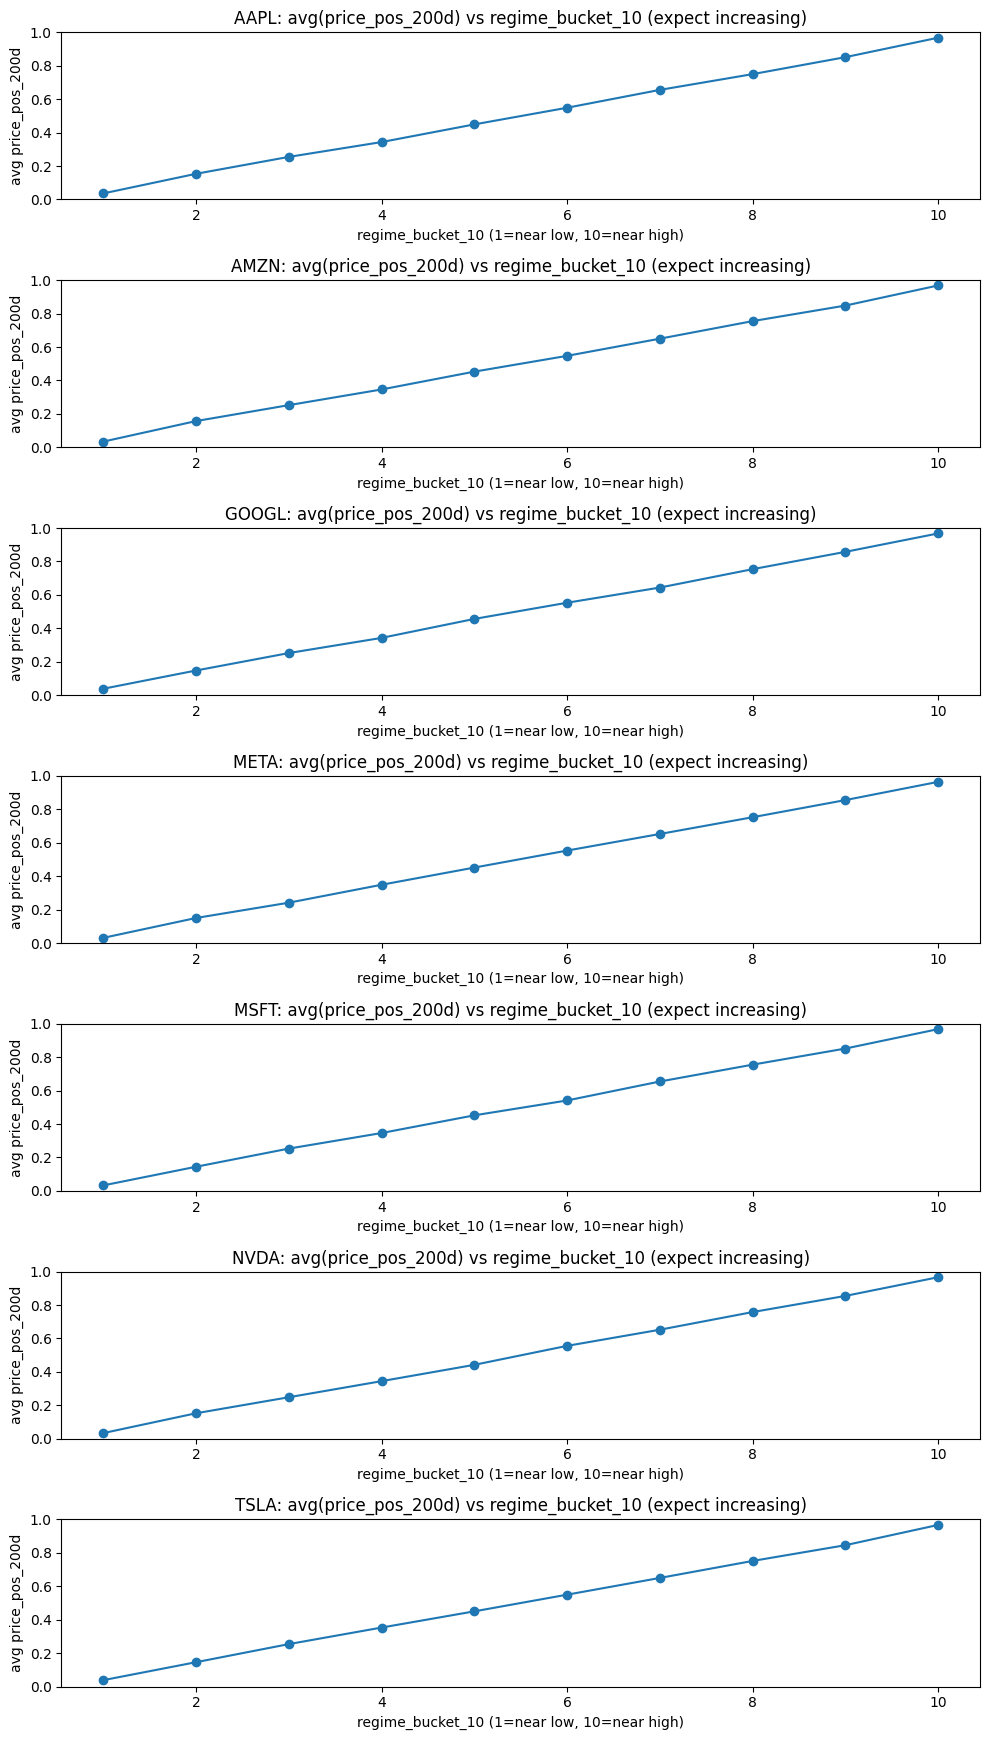

In [14]:
tickers = sorted(df["ticker"].unique())
n = len(tickers)

fig_h = max(4, 2.5 * n)
plt.figure(figsize=(10, fig_h))

for i, t in enumerate(tickers, start=1):
    sub = bucket_pos[bucket_pos["ticker"] == t].sort_values("regime_bucket_10")
    plt.subplot(n, 1, i)
    plt.plot(sub["regime_bucket_10"], sub["avg"], marker="o")
    plt.ylim(0, 1)
    plt.title(f"{t}: avg(price_pos_200d) vs regime_bucket_10 (expect increasing)")
    plt.xlabel("regime_bucket_10 (1=near low, 10=near high)")
    plt.ylabel("avg price_pos_200d")

plt.tight_layout()
plt.show()


**Assessment**
✅ price_pos_200d is linearly increasing per regime bucket  
✅ bucketing logic is mathematically correct

### 8. Z-score decile balance check

In [ ]:
z_counts = (
    df.groupby(["ticker", "zscore_bucket_10"])
      .size()
      .reset_index(name="n")
      .sort_values(["ticker", "zscore_bucket_10"])
)
z_counts.head(20)

,ticker,zscore_bucket_10,n
0,AAPL,1,149
1,AAPL,2,150
2,AAPL,3,150
3,AAPL,4,149
4,AAPL,5,149
5,AAPL,6,149
6,AAPL,7,149
7,AAPL,8,149
8,AAPL,9,149
9,AAPL,10,149


**Assessment**
Are zscore_bucket_10 buckets balanced and unbiased within each ticker?

### 9. Plot zscore bucket balance (bar chart per ticker)

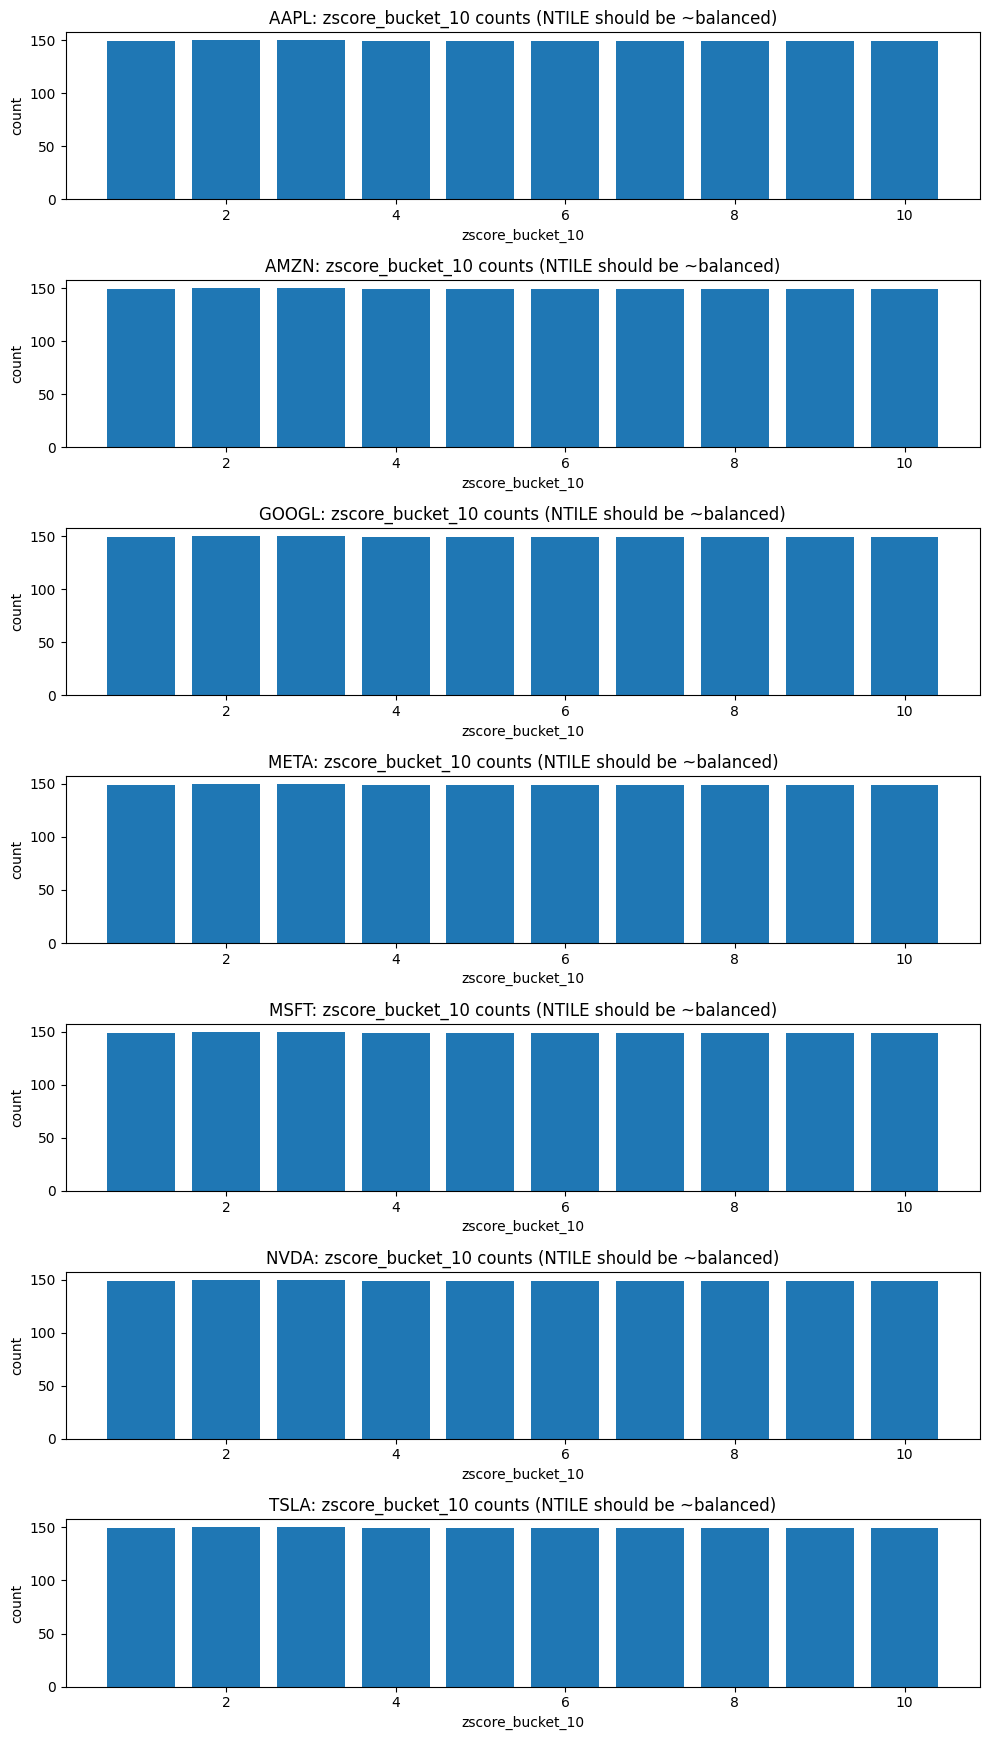

In [16]:
tickers = sorted(df["ticker"].unique())
n = len(tickers)

fig_h = max(4, 2.5 * n)
plt.figure(figsize=(10, fig_h))

for i, t in enumerate(tickers, start=1):
    sub = z_counts[z_counts["ticker"] == t]
    plt.subplot(n, 1, i)
    plt.bar(sub["zscore_bucket_10"], sub["n"])
    plt.title(f"{t}: zscore_bucket_10 counts (NTILE should be ~balanced)")
    plt.xlabel("zscore_bucket_10")
    plt.ylabel("count")

plt.tight_layout()
plt.show()


✅ The z-score buckets are evenly populated
✅ No bucket is over- or under-represented
✅ No time-period bias
✅ No skew from missing data or bad ordering

Cell 11 — Summary stats by bucket

In [17]:
perf = (
    df.groupby(["ticker", "regime_bucket_10"])
      .agg(
          n=("fwd_return_20d","size"),
          avg_5d=("fwd_return_5d","mean"),
          avg_20d=("fwd_return_20d","mean"),
          p50_5d=("fwd_return_5d","median"),
          p50_20d=("fwd_return_20d","median"),
          win_5d=("fwd_return_5d", lambda x: (x > 0).mean()),
          win_20d=("fwd_return_20d", lambda x: (x > 0).mean()),
      )
      .reset_index()
)

perf.head()


,ticker,regime_bucket_10,n,avg_5d,avg_20d,p50_5d,p50_20d,win_5d,win_20d
0,AAPL,1,55,0.023341,0.073460,0.020970,0.089165,0.709091,0.800000
1,AAPL,2,56,0.018037,0.057096,0.015979,0.058652,0.625000,0.642857
2,AAPL,3,59,0.004807,0.022892,0.015186,0.033913,0.593220,0.610169
3,AAPL,4,88,-0.000705,0.010257,0.006219,0.022280,0.522727,0.590909
4,AAPL,5,103,-0.005976,0.003155,-0.004641,-0.031436,0.436893,0.446602


### 11. Plot: avg forward returns by bucket

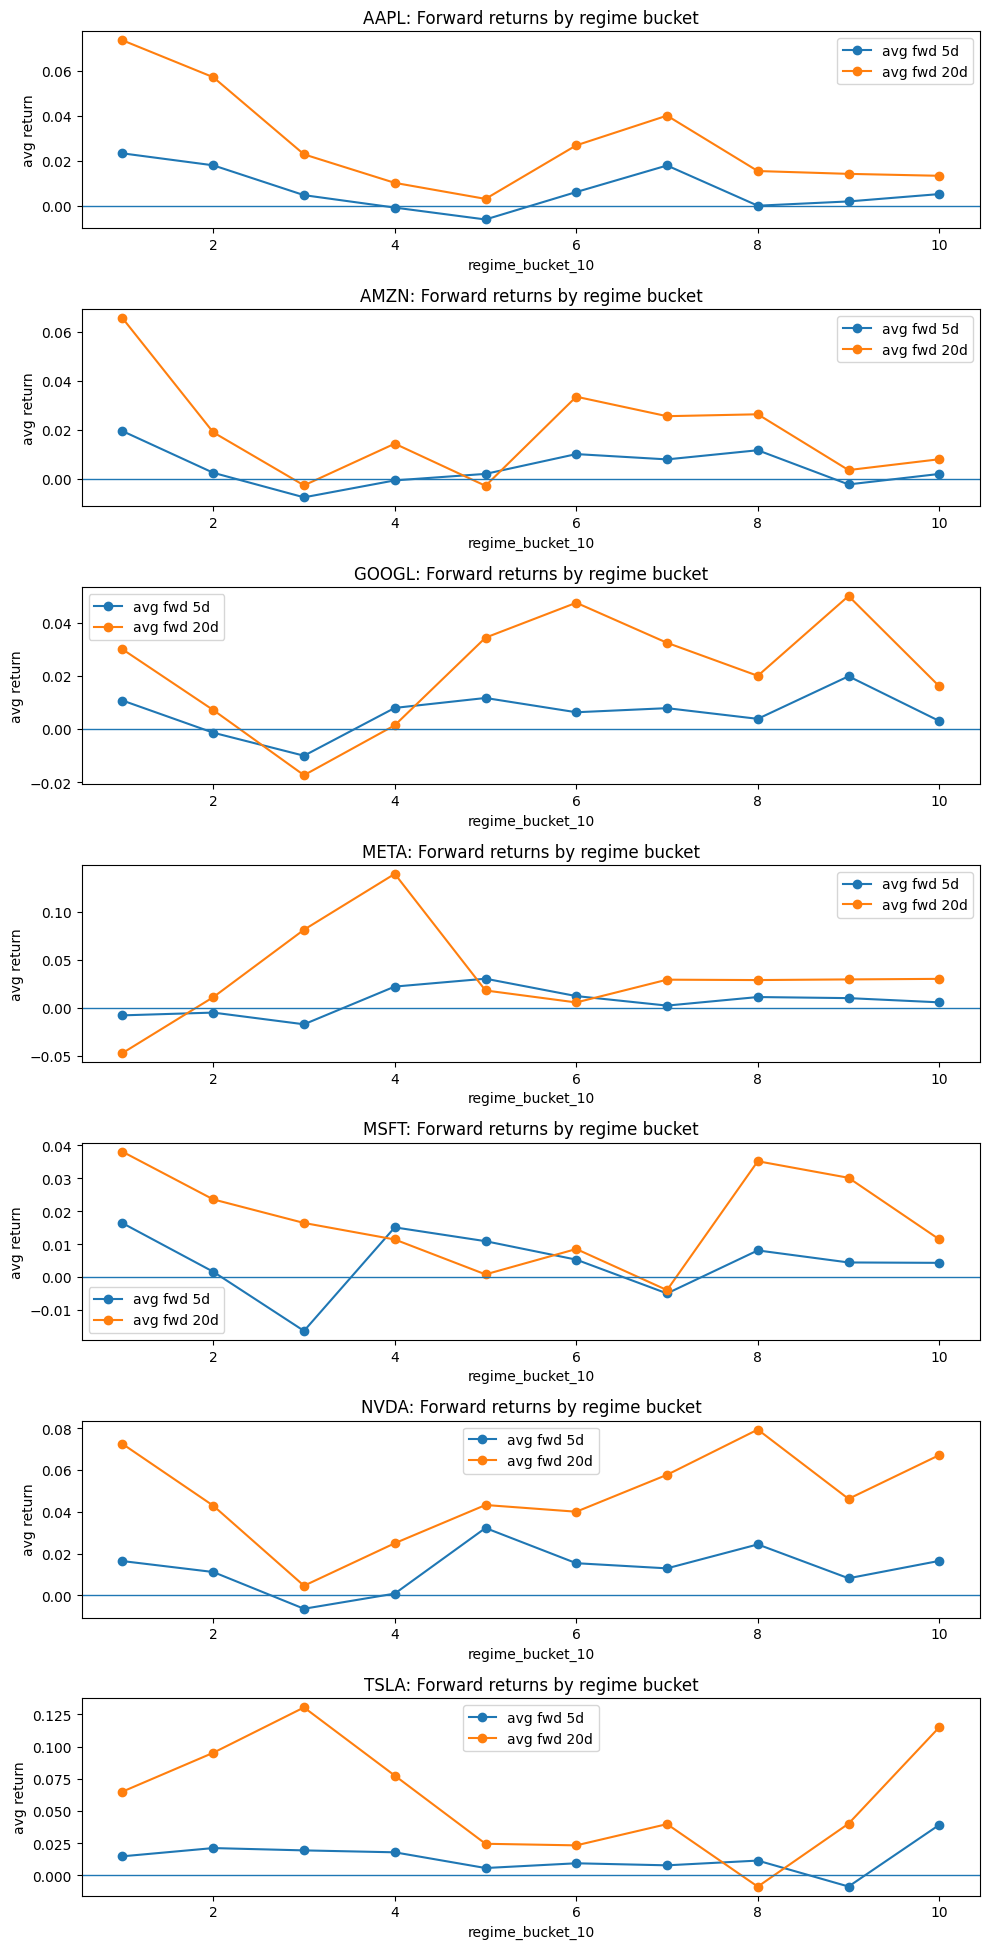

In [18]:
tickers = sorted(df["ticker"].unique())
n = len(tickers)
fig_h = max(4, 2.8 * n)

plt.figure(figsize=(10, fig_h))
for i, t in enumerate(tickers, start=1):
    sub = perf[perf["ticker"] == t].sort_values("regime_bucket_10")
    plt.subplot(n, 1, i)
    plt.plot(sub["regime_bucket_10"], sub["avg_5d"], marker="o", label="avg fwd 5d")
    plt.plot(sub["regime_bucket_10"], sub["avg_20d"], marker="o", label="avg fwd 20d")
    plt.axhline(0, linewidth=1)
    plt.title(f"{t}: Forward returns by regime bucket")
    plt.xlabel("regime_bucket_10")
    plt.ylabel("avg return")
    plt.legend()

plt.tight_layout()
plt.show()


🎯 Bootstrap confidence intervals (avoid “pretty but fake”)

Cell 13 — Bootstrap helper

In [19]:
def bootstrap_mean_ci(x, n_boot=2000, alpha=0.05, seed=7):
    x = np.asarray(x)
    x = x[~np.isnan(x)]
    if len(x) < 30:
        return (np.nan, np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = rng.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    lo = np.quantile(boots, alpha/2)
    hi = np.quantile(boots, 1 - alpha/2)
    return (x.mean(), lo, hi)


In [ ]:
Cell 14 — Compute bootstrap CI per ticker × bucket for fwd_return_20d

In [20]:
rows = []
for (ticker, b), g in df.groupby(["ticker", "regime_bucket_10"]):
    mean, lo, hi = bootstrap_mean_ci(g["fwd_return_20d"].values)
    rows.append({
        "ticker": ticker,
        "bucket": int(b),
        "n": len(g),
        "mean_20d": mean,
        "ci_lo": lo,
        "ci_hi": hi
    })

ci = pd.DataFrame(rows).sort_values(["ticker","bucket"])
ci.head(20)


,ticker,bucket,n,mean_20d,ci_lo,ci_hi
0,AAPL,1,55,0.073460,0.047332,0.098288
1,AAPL,2,56,0.057096,0.034600,0.080304
2,AAPL,3,59,0.022892,0.001683,0.042842
3,AAPL,4,88,0.010257,-0.006609,0.026679
4,AAPL,5,103,0.003155,-0.012973,0.019625
5,AAPL,6,85,0.026889,0.006771,0.045850
6,AAPL,7,167,0.040063,0.029121,0.049375
7,AAPL,8,218,0.015502,0.006716,0.024365
8,AAPL,9,263,0.014246,0.005160,0.024616
9,AAPL,10,398,0.013394,0.004608,0.021513


Cell 15 — Plot: mean ± CI bands (fwd 20d) by bucket

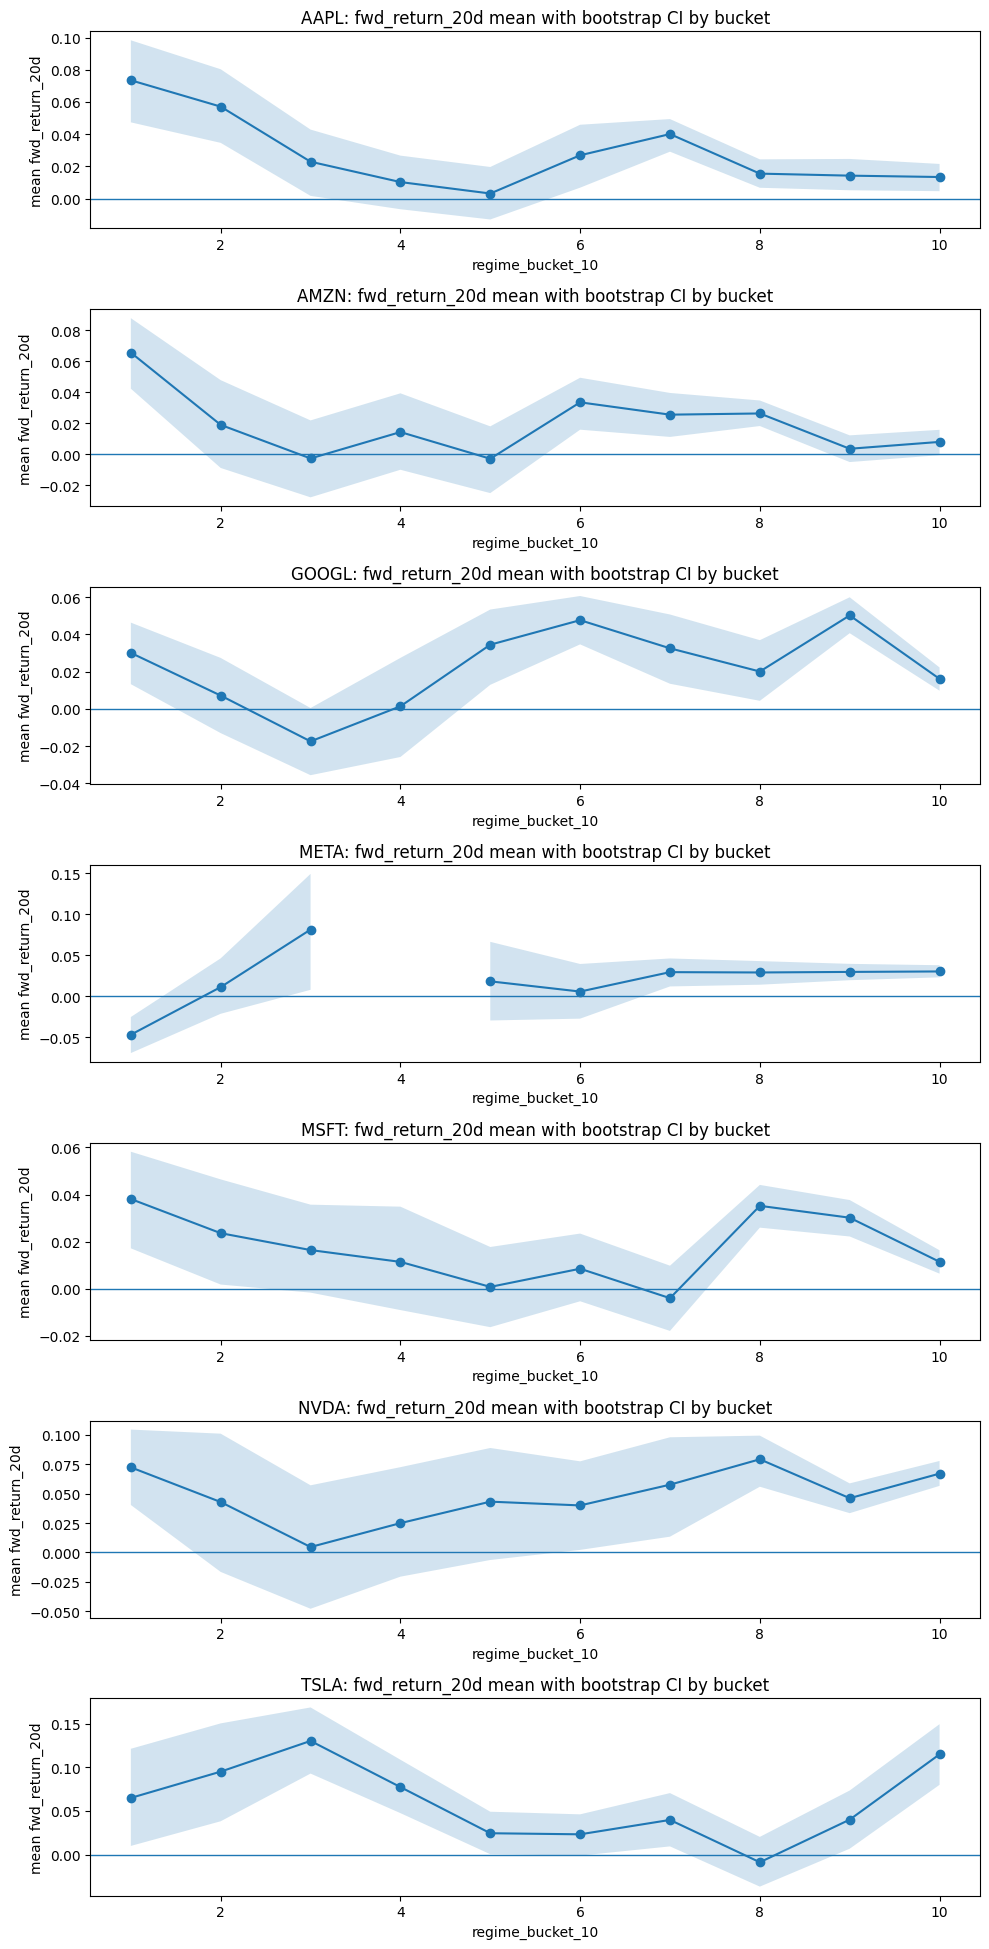

In [ ]:
tickers = sorted(df["ticker"].unique())
n = len(tickers)
fig_h = max(4, 2.8 * n)

plt.figure(figsize=(10, fig_h))
for i, t in enumerate(tickers, start=1):
    sub = ci[ci["ticker"] == t].sort_values("bucket")
    x = sub["bucket"].values
    y = sub["mean_20d"].values
    lo = sub["ci_lo"].values
    hi = sub["ci_hi"].values

    plt.subplot(n, 1, i)
    plt.plot(x, y, marker="o")
    plt.fill_between(x, lo, hi, alpha=0.2)
    plt.axhline(0, linewidth=1)
    plt.title(f"{t}: fwd_return_20d mean with bootstrap CI by bucket")
    plt.xlabel("regime_bucket_10")
    plt.ylabel("mean fwd_return_20d")

plt.tight_layout()
plt.show()


🧪 Stability (time splits)

Cell 16 — Add year and compute by-year bucket means

In [22]:
df2 = df.copy()
df2["year"] = df2["trade_date"].dt.year

by_year = (
    df2.groupby(["ticker","year","regime_bucket_10"])
       .agg(n=("fwd_return_20d","size"),
            avg_20d=("fwd_return_20d","mean"),
            win_20d=("fwd_return_20d", lambda x: (x > 0).mean()))
       .reset_index()
)

by_year.head()


,ticker,year,regime_bucket_10,n,avg_20d,win_20d
0,AAPL,2020,1,12,0.039240,0.583333
1,AAPL,2020,2,6,0.090658,0.666667
2,AAPL,2020,3,7,0.045788,0.714286
3,AAPL,2020,4,7,0.027583,0.571429
4,AAPL,2020,5,8,0.067887,0.625000


Cell 17 — Heatmap-style plot (year × bucket → avg fwd 20d)

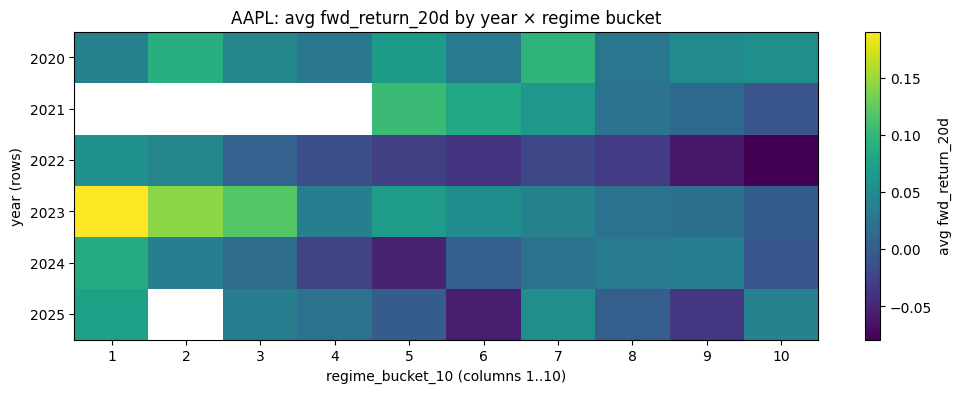

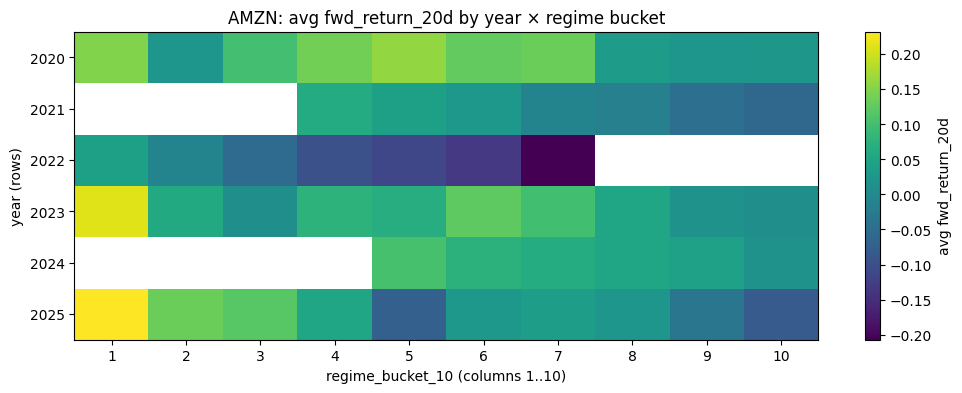

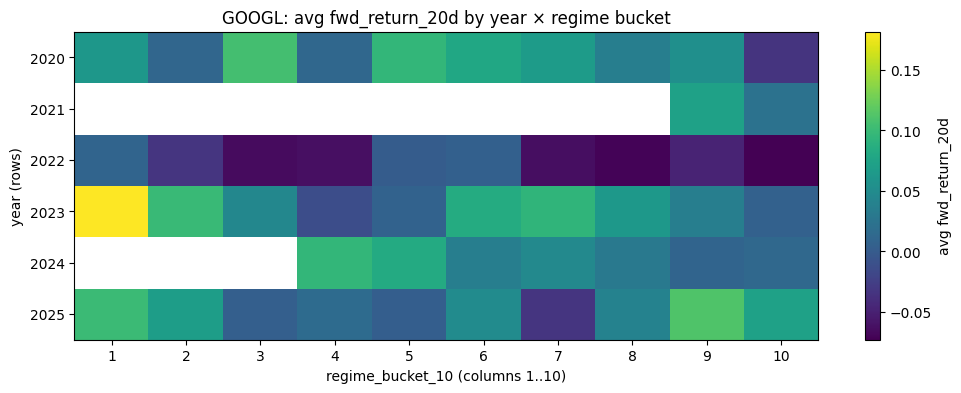

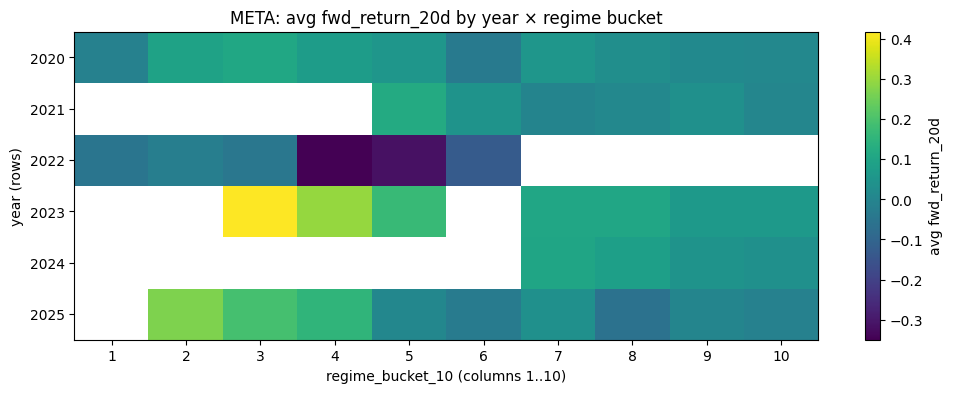

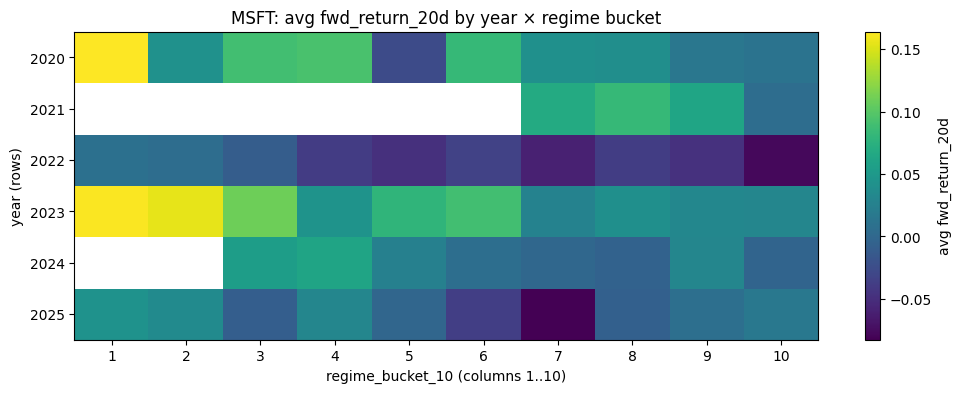

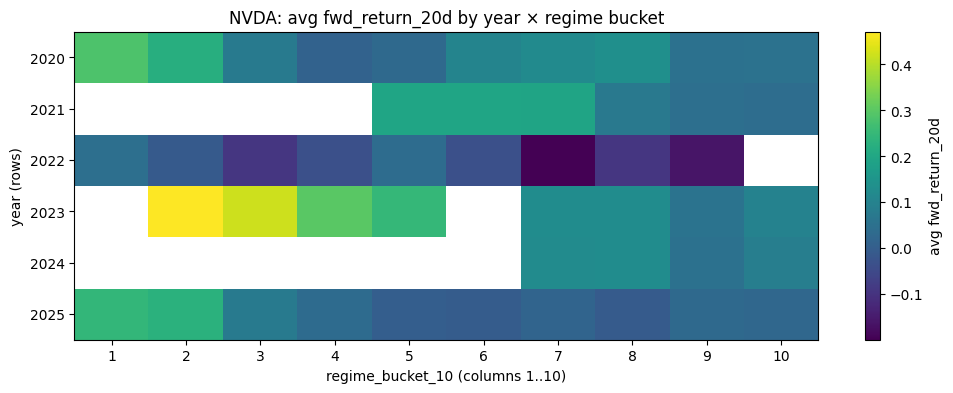

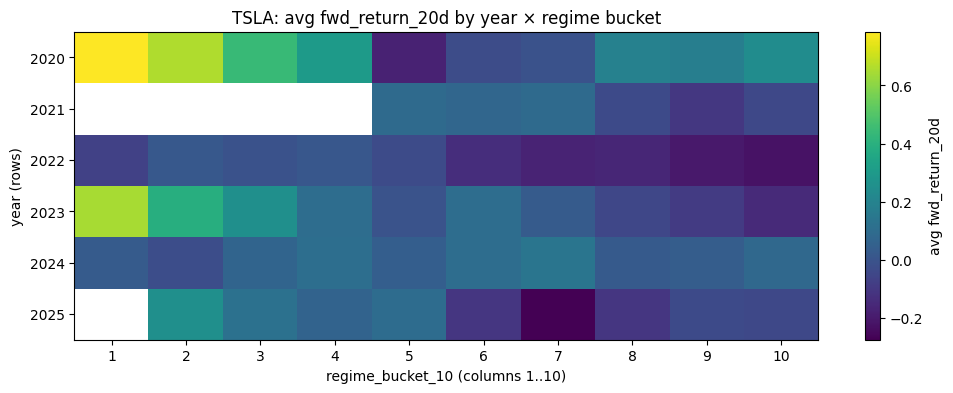

In [23]:
tickers = sorted(df2["ticker"].unique())

for t in tickers:
    sub = by_year[by_year["ticker"] == t]
    pivot = sub.pivot(index="year", columns="regime_bucket_10", values="avg_20d").sort_index()

    plt.figure(figsize=(12, 4))
    plt.imshow(pivot.values, aspect="auto")
    plt.title(f"{t}: avg fwd_return_20d by year × regime bucket")
    plt.xlabel("regime_bucket_10 (columns 1..10)")
    plt.ylabel("year (rows)")
    plt.colorbar(label="avg fwd_return_20d")
    plt.xticks(range(pivot.shape[1]), pivot.columns.tolist())
    plt.yticks(range(pivot.shape[0]), pivot.index.tolist())
    plt.show()


✅ “Pass / Fail” checklist (Markdown)

## NB1 Pass / Fail

Pass if:
- avg(price_pos_200d) increases with regime_bucket_10 (per ticker)
- zscore_bucket_10 counts are roughly balanced (per ticker)
- regime bucket performance patterns are stable across years (not a single-year artifact)
- bootstrap CI suggests meaningful separation for at least some buckets / styles

If fail:
- fix data/feature definitions (rolling windows, forward returns, missing periods)
- consider adding conditioning (volatility/macro) before claiming alpha
